# Deeplearning Project (PyTorch)
## Application of Mamba Model on Time Series Forecasting
### Author: ZHANG Xiaopeng

This notebook is dedicated to the full workflow of time series forcasting using multiple state-of-art `torch.nn` based models applied to a synthetical dataset of sine waves. It encompasses all steps including data generation; data preprocessing(generation of the sliding window for time series data); model construction by importing from `torch` and other online repository like `s4` and `mamba` which are some novel models which have ever intergrated the idea of SSM(State Space Model) into a neural network architecture; model training

# 0. Data preprocessing 

## Description
The synthetical time series data is first generated using the following formula:  
$$y = 10\sin(x) + 3\sin(20x) + 2\sin(2x)$$
The data is then capsuled by `TimeSeriesDataset` class for further usage. The class automatically create a sliding window with **1 unit shift** for each unit sequence with input sequence length $L_{in}$ and output sequence length $L_{out}$. The expression below presents the general model according to this setting: 
$$
\begin{pmatrix} \hat{x}_{L_{in}+1}\\ \vdots\\ \hat{x}_{L_{in}+L_{out}}
\end{pmatrix} = \text{f}
\begin{pmatrix} x_1\\ \vdots\\ x_{L_{in}}
\end{pmatrix}
$$

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

input_len = 8 * 6
output_len = 8 * 6


# Generate sine data
def generate_data(num_points):
    x = np.linspace(0, 3 * np.pi, num_points)
    data = np.sin(x)*10 + np.sin(x*20)*3 + np.sin(x*2)*2
    return data


class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len, output_len):
        self.data = data
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.data) - self.input_len - self.output_len

    def __getitem__(self, idx):
        input_seq = self.data[idx:idx + self.input_len]
        target_seq = self.data[idx +
                                    self.input_len:idx + self.input_len + self.output_len]
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)


# train set : idx in [0, 800]
# validation set : idx in [801, 1000]
# test set : idx in [1001, 1250]

scaler = StandardScaler()
# Generate 1000 points of sine and cosine data
num_points = 1250 + input_len + output_len
sine_data = generate_data(num_points)
sine_data = scaler.fit_transform(sine_data.reshape(-1, 1)).flatten()

# Create dataset and split into training and testing sets
dataset = TimeSeriesDataset(sine_data, input_len, output_len)

train_size = 800
val_size = 200
test_size = 250
batch_size = 32
train_dataset, val_dataset, test_dataset = Subset(dataset, range(train_size)), Subset(
    dataset, range(train_size, train_size+val_size)), Subset(dataset, range(train_size+val_size, len(dataset)))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [2]:
# Test block
for i, (input_seq, target_seq) in enumerate(train_loader):
    print(f'input_seq shape: {input_seq.shape}')
    print(f'target_seq shape: {target_seq.shape}')
    break

input_seq shape: torch.Size([32, 48])
target_seq shape: torch.Size([32, 48])


`train_loader`, `val_loader`, `test_loader` are the batched datasets of `TimeseriesDataset`. The batching process is designed to further parallelize training and boost GPU performance. The total number of sequences in each batch is defined by `batch_size`, and if the Euclidien division of the total sequences number by `batch_size` has a non-zero rest, then the **last batch has the `rest_size` as its size**.

In [5]:
# Test block
# dataloader test -> check the shape of inputs and targets
# s1 = 0
# s2 = 0
# for batch_idx, (inputs, targets) in enumerate(train_loader):
#     s1 += inputs.shape[0]
#     s2 += targets.shape[0]
#     print(f"Batch {batch_idx+1}")
#     assert inputs.shape[0] == targets.shape[0]
#     print(f"Total sequences in current batch: {inputs.shape[0]}")
#     print("accumulated Input size:", s1)
#     print("accumulated Target size:", s2)
# s1 = 0
# s2 = 0
# for batch_idx, (inputs, targets) in enumerate(val_loader):
#     s1 += inputs.shape[0]
#     s2 += targets.shape[0]
#     print(f"Batch {batch_idx+1}")
#     assert inputs.shape[0] == targets.shape[0]
#     print(f"Total sequences in current batch: {inputs.shape[0]}")
#     print("accumulated Input size:", s1)
#     print("accumulated Target size:", s2)
s1 = 0
s2 = 0
for batch_idx, (inputs, targets) in enumerate(test_loader):
    s1 += inputs.shape[0]
    s2 += targets.shape[0]
    print(f"Batch {batch_idx+1}")
    assert inputs.shape[0] == targets.shape[0]
    print(f"Total sequences in current batch: {inputs.shape[0]}")
    print("accumulated Input size:", s1)
    print("accumulated Target size:", s2)

Batch 1
Total sequences in current batch: 32
accumulated Input size: 32
accumulated Target size: 32
Batch 2
Total sequences in current batch: 32
accumulated Input size: 64
accumulated Target size: 64
Batch 3
Total sequences in current batch: 32
accumulated Input size: 96
accumulated Target size: 96
Batch 4
Total sequences in current batch: 32
accumulated Input size: 128
accumulated Target size: 128
Batch 5
Total sequences in current batch: 32
accumulated Input size: 160
accumulated Target size: 160
Batch 6
Total sequences in current batch: 32
accumulated Input size: 192
accumulated Target size: 192
Batch 7
Total sequences in current batch: 32
accumulated Input size: 224
accumulated Target size: 224
Batch 8
Total sequences in current batch: 26
accumulated Input size: 250
accumulated Target size: 250


In [6]:
# Test block
len(dataset)

1250

In [7]:
# Test block
# dataloader test -> check the total number of batches
print(f"Total number of batches: {len(train_loader)}")

Total number of batches: 25


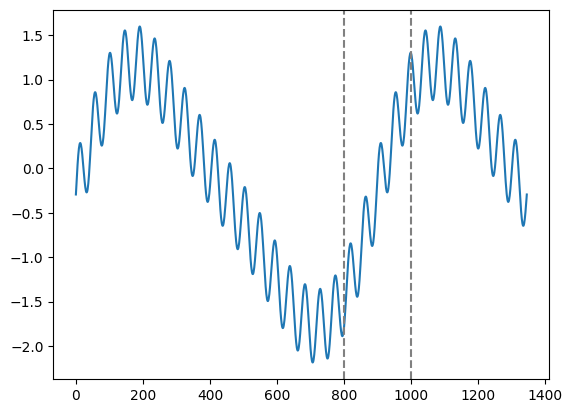

In [8]:
# Data visualization
plt.plot(sine_data)
plt.axvline(x=train_size, color='gray', linestyle='--')  # Vertical line separating input and output
plt.axvline(x=train_size+val_size, color='gray', linestyle='--')  # Vertical line separating input and output

## Patch embedding time series forcasting

 The architecture we employ is similar to PatchTST, incorporating a patch layer, a Transformer block, and a flatten layer. The patch layer segments the time series data into smaller patches, enabling the model to capture local temporal patterns. These patches are then processed through the Transformer block, which leverages self-attention mechanisms to identify complex temporal dependencies across the entire series. Finally, the flatten layer consolidates the output for subsequent forecasting steps. By training this model on historical data, we aim to predict multiple future time steps and evaluate its performance against established benchmarks.


<div style="text-align: center;">
    <img src="imgs/patch_transformer.png" alt="image" style="width:800px;"/>
</div>


Architecture of Transformer-based Model (Simplified PatchTST)
- ``Linear Patching Layer`` : The input sequence is segmented into patches and linearly projected.
-`` Transformer Layer``: The patches are processed through the Transformer Layer, capturing dependencies and patterns
- ``Flatten Layer``: The output from the Transformer Layer is flattened into a two-dimensional matrix
- ``Linear Layer``: The flattened features are mapped to the target sequence length through a final linear transformation

<div style="text-align: center;">
    <img src="imgs/transformer_model.png" alt="image" style="width:200px;"/>
</div>

**Task to do :**
- Build a ``Model``, ``DataLoader``for time series forecasting with Transformer based model.
- Set loss function with Mean Square Error (``MSE``), measuring the error between predicted value and groundtruth time series.
- Build ``Experiment`` and examine the performance of model.
- Make a conclusion with experiment result.

The recommanded parameters are:
- ``input_length`` : 6*8 # the input time series length
- ``output_length`` : 6*8 # the output time series length
- ``patch_size`` : 32 # the patch length, which impicate that the attention matrix size is 6*6
- ``d_model``: 64 # dimension of the Q K V in transformer layer
- ``nhead``: 2 # number of splits in Q K V, which represents the independent resion in the matrix multiplication.
- ``num_encoder_layers``: 1 # number of attention layer in transformer
- ``dim_feedforward``: 256 # the final output project dimension

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import pickle as pkl

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, d_model):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Linear(patch_size, d_model)

    def forward(self, x):
        B, L = x.shape
        x = x.view(B, L // self.patch_size, self.patch_size)
        # [ [0, 0, 0, 0]   ->  [ [[0, 0],[0, 0]]
        #   [0, 0, 0, 0] ]       [[0, 0],[0, 0]] ] 
        # 2*4 -> 2*2*2
        x = self.proj(x)
        return x
        # the returned shape should be (B, L // patch_size, d_model)


class TransformerModel(nn.Module):
    def __init__(self, patch_size, d_model, nhead, num_encoder_layers,
                 dim_feedforward, dropout, output_len, num_features=1):
        super(TransformerModel, self).__init__()
        self.patch_embed = PatchEmbedding(patch_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        self.flatten = nn.Flatten()
        self.fc_out = nn.Linear(d_model * (output_len // patch_size), output_len)

    def forward(self, src):
        src = self.patch_embed(src)
        src = self.transformer_encoder(src)
        src = self.flatten(src)
        output = self.fc_out(src)
        return output

# Hyperparameters
input_len = 8 * 6
output_len = 8 * 6  # number of steps to predict
patch_size = 8
d_model = 64
nhead = 2
num_encoder_layers = 3
dim_feedforward = 256
dropout = 0.1

# Model initialization
model = TransformerModel(patch_size, d_model, nhead, num_encoder_layers,
                         dim_feedforward, dropout, output_len)

# Example input
x = torch.rand(32, 48)  # batch size 32, sequence length 96
output = model(x)
print(output.shape)  # should be (32, output_len)

torch.Size([32, 48])


c:\Users\张晓鹏\Desktop\test\myenv\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


**Testing on patch embedding**
It is notable that the last feature size of the input tensor $x$(ex. `x.shape`=`(1,2,5)`, then the input feature should be `5`) should match the input size of `nn.Linear`, otherwise the network would fail. 

THE `nn.Linear` only transforms the last feature of a tensor -> SEE Test below

In [11]:
# TEST nn.Linear
x = np.random.rand(8, 10)
x = torch.tensor(x, dtype=torch.float32)
fc = nn.Linear(10,5)
fc(x).shape

torch.Size([8, 5])

In [12]:
fc = PatchEmbedding(2, 4)
fc.forward(x).shape

torch.Size([8, 5, 4])

In [13]:
# Model initialization
model = TransformerModel(patch_size, d_model, nhead, num_encoder_layers,
                         dim_feedforward, dropout, output_len)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        input_seq, target_seq = batch
        optimizer.zero_grad()
        output = model(input_seq)
        loss = criterion(output, target_seq)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    #train_losses.append(train_loss)

    # Testing the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            input_seq, target_seq = batch
            output = model(input_seq)
            loss = criterion(output, target_seq)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    #val_losses.append(val_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            input_seq, target_seq = batch
            output = model(input_seq)
            loss = criterion(output, target_seq)
            test_loss += loss.item()
    test_loss /= len(test_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/50, Training Loss: 0.3439, Validation Loss: 0.8603, Test Loss: 0.1333
Epoch 2/50, Training Loss: 0.1521, Validation Loss: 0.4767, Test Loss: 0.0820
Epoch 3/50, Training Loss: 0.1019, Validation Loss: 0.5084, Test Loss: 0.0422
Epoch 4/50, Training Loss: 0.0879, Validation Loss: 0.6359, Test Loss: 0.0811
Epoch 5/50, Training Loss: 0.0757, Validation Loss: 0.2210, Test Loss: 0.0484
Epoch 6/50, Training Loss: 0.0595, Validation Loss: 0.3017, Test Loss: 0.0285
Epoch 7/50, Training Loss: 0.0416, Validation Loss: 0.2943, Test Loss: 0.0201
Epoch 8/50, Training Loss: 0.0324, Validation Loss: 0.1891, Test Loss: 0.0313
Epoch 9/50, Training Loss: 0.0256, Validation Loss: 0.1277, Test Loss: 0.0222
Epoch 10/50, Training Loss: 0.0273, Validation Loss: 0.1231, Test Loss: 0.0135
Epoch 11/50, Training Loss: 0.0226, Validation Loss: 0.1372, Test Loss: 0.0165
Epoch 12/50, Training Loss: 0.0194, Validation Loss: 0.1326, Test Loss: 0.0244
Epoch 13/50, Training Loss: 0.0176, Validation Loss: 0.1013, 

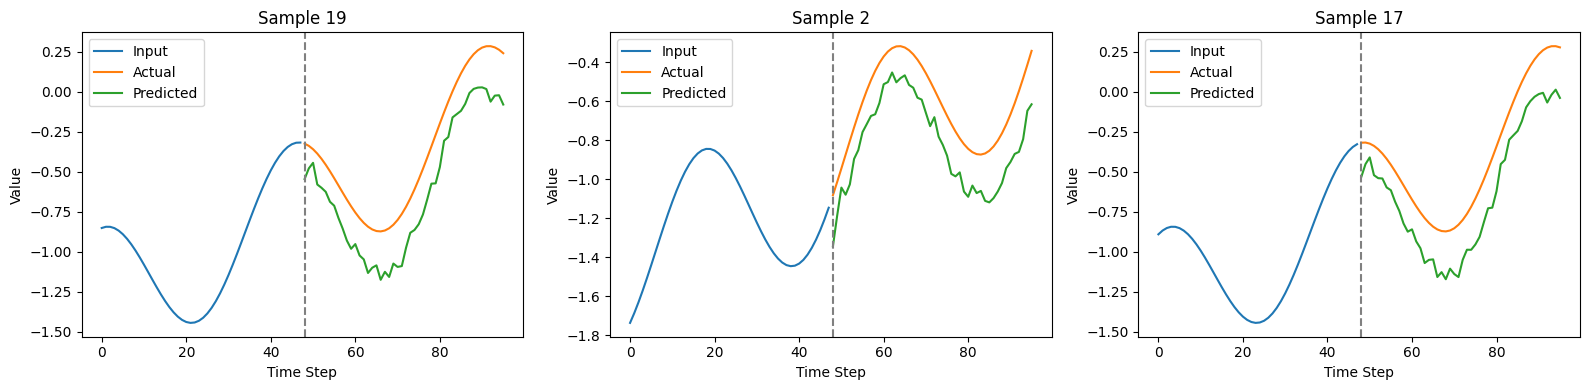

In [14]:
import random
# Randomly select data samples and visualize results
input_seq, target_seq = next(iter(val_loader))
output = model(input_seq)

# Randomly select 3 samples to visualize
sample_indices = random.sample(range(input_seq.size(0)), 3)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for idx, i in enumerate(sample_indices):
    axs[idx].plot(range(input_len), input_seq[i].numpy(), label='Input')
    axs[idx].plot(range(input_len, input_len + output_len), target_seq[i].detach().numpy(), label='Actual')
    axs[idx].plot(range(input_len, input_len + output_len), output[i].detach().numpy(), label='Predicted')
    axs[idx].axvline(x=input_len, color='gray', linestyle='--')  # Vertical line separating input and output
    axs[idx].set_title(f'Sample {i+1}')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()

plt.tight_layout()
plt.show()

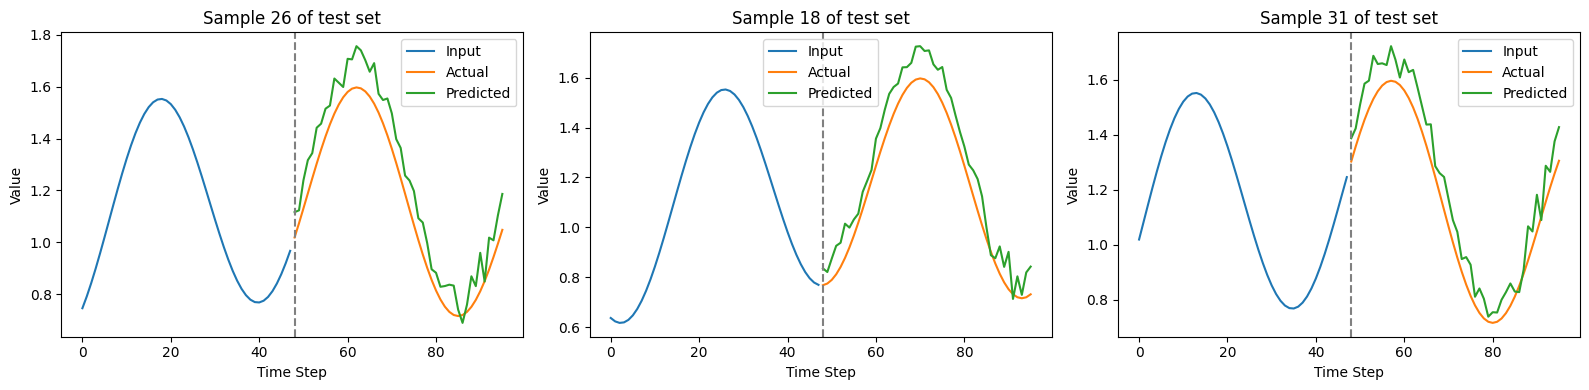

In [15]:
# Test the model on the test set
input_seq, target_seq = next(iter(test_loader))
output = model(input_seq)

# Randomly select 3 samples to visualize
sample_indices = random.sample(range(input_seq.size(0)), 3)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for idx, i in enumerate(sample_indices):
    axs[idx].plot(range(input_len), input_seq[i].numpy(), label='Input')
    axs[idx].plot(range(input_len, input_len + output_len), target_seq[i].detach().numpy(), label='Actual')
    axs[idx].plot(range(input_len, input_len + output_len), output[i].detach().numpy(), label='Predicted')
    axs[idx].axvline(x=input_len, color='gray', linestyle='--')  # Vertical line separating input and output
    axs[idx].set_title(f'Sample {i+1} of test set')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()

plt.tight_layout()
plt.show()

# 2. RNN

In [15]:
# Redefine patch embedding
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, d_model):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Linear(patch_size, d_model)

    def forward(self, x):
        B, L = x.shape
        x = x.view(B, L // self.patch_size, self.patch_size)
        x = self.proj(x)
        return x

# Example usage
patch_size = 6
d_model = 10
input_tensor = torch.randn(32, 48) 
# it is also notable that the input tensor should be 2D and patch_size should be a factor of the sequence length
patch_embed = PatchEmbedding(patch_size, d_model)
output = patch_embed(input_tensor)
output.shape

torch.Size([32, 8, 10])

In [16]:
# Model initialization RNN model
import torch
import torch.nn as nn

class CustomRNN(nn.Module):
    def __init__(self, patch_size, d_model, hidden_size, num_layers, output_size, feature_size=1):
        super(CustomRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(feature_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.patch_embed = PatchEmbedding(patch_size, d_model)

    def forward(self, x):
        x = self.patch_embed(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[ :, -1, :])
        return out

# Hyperparameters
hidden_size = 50
num_layers = 2
input_len = 8 * 6
output_len = 8 * 6  # number of steps to predict
patch_size = 8
d_model = 64
feature_size = d_model

model = CustomRNN(patch_size, d_model, hidden_size, num_layers, output_size=output_len, feature_size=feature_size)


In [17]:
# Model initialization Transformer 
# model = TransformerModel(patch_size, d_model, nhead, num_encoder_layers,
#                          dim_feedforward, dropout, output_len)

# Model initialization RNN 
model = CustomRNN(patch_size, d_model, hidden_size, num_layers, output_size=output_len, feature_size=feature_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        input_seq, target_seq = batch
        # input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
        optimizer.zero_grad()
        output = model(input_seq)
        loss = criterion(output, target_seq)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Testing the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            input_seq, target_seq = batch
            # input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
            output = model(input_seq)
            loss = criterion(output, target_seq)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            input_seq, target_seq = batch
            # input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
            output = model(input_seq)
            loss = criterion(output, target_seq)
            test_loss += loss.item()
    test_loss /= len(test_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/50, Training Loss: 0.6890, Validation Loss: 0.5093, Test Loss: 0.2989
Epoch 2/50, Training Loss: 0.2170, Validation Loss: 0.3572, Test Loss: 0.1577
Epoch 3/50, Training Loss: 0.1469, Validation Loss: 0.3218, Test Loss: 0.0931
Epoch 4/50, Training Loss: 0.1034, Validation Loss: 0.1868, Test Loss: 0.0481
Epoch 5/50, Training Loss: 0.0619, Validation Loss: 0.1252, Test Loss: 0.0240
Epoch 6/50, Training Loss: 0.0379, Validation Loss: 0.0723, Test Loss: 0.0104
Epoch 7/50, Training Loss: 0.0262, Validation Loss: 0.0433, Test Loss: 0.0071
Epoch 8/50, Training Loss: 0.0208, Validation Loss: 0.0381, Test Loss: 0.0107
Epoch 9/50, Training Loss: 0.0187, Validation Loss: 0.0270, Test Loss: 0.0037
Epoch 10/50, Training Loss: 0.0138, Validation Loss: 0.0264, Test Loss: 0.0102
Epoch 11/50, Training Loss: 0.0109, Validation Loss: 0.0201, Test Loss: 0.0029
Epoch 12/50, Training Loss: 0.0099, Validation Loss: 0.0224, Test Loss: 0.0072
Epoch 13/50, Training Loss: 0.0101, Validation Loss: 0.0171, 

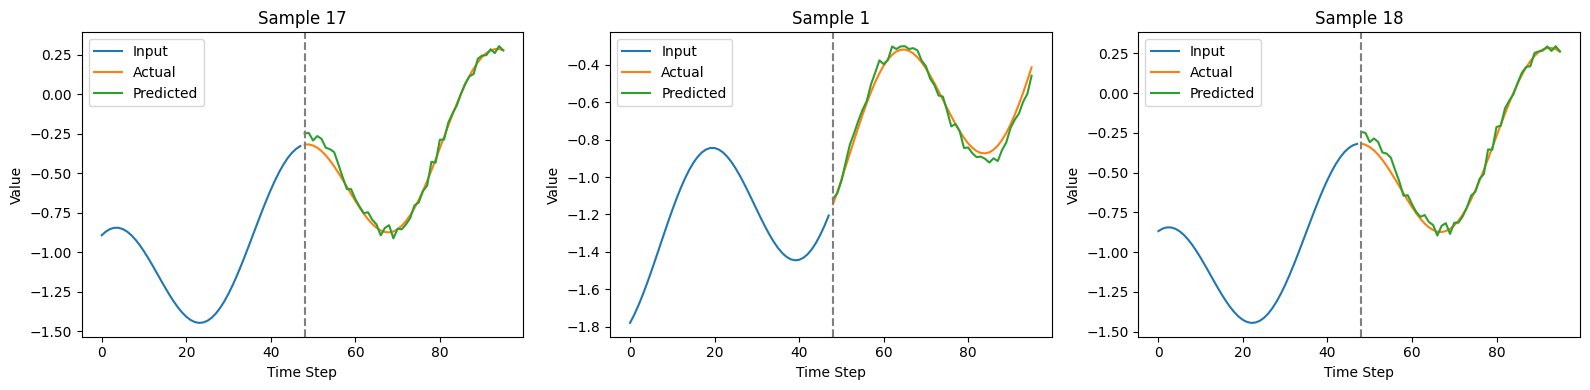

In [18]:
import random
# Randomly select data samples and visualize results
input_seq, target_seq = next(iter(val_loader))
# input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
output = model(input_seq)

# Randomly select 3 samples to visualize
sample_indices = random.sample(range(input_seq.size(0)), 3)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for idx, i in enumerate(sample_indices):
    axs[idx].plot(range(input_len), input_seq[i].numpy(), label='Input')
    axs[idx].plot(range(input_len, input_len + output_len), target_seq[i].detach().numpy(), label='Actual')
    axs[idx].plot(range(input_len, input_len + output_len), output[i].detach().numpy(), label='Predicted')
    axs[idx].axvline(x=input_len, color='gray', linestyle='--')  # Vertical line separating input and output
    axs[idx].set_title(f'Sample {i+1}')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()

plt.tight_layout()
plt.show()

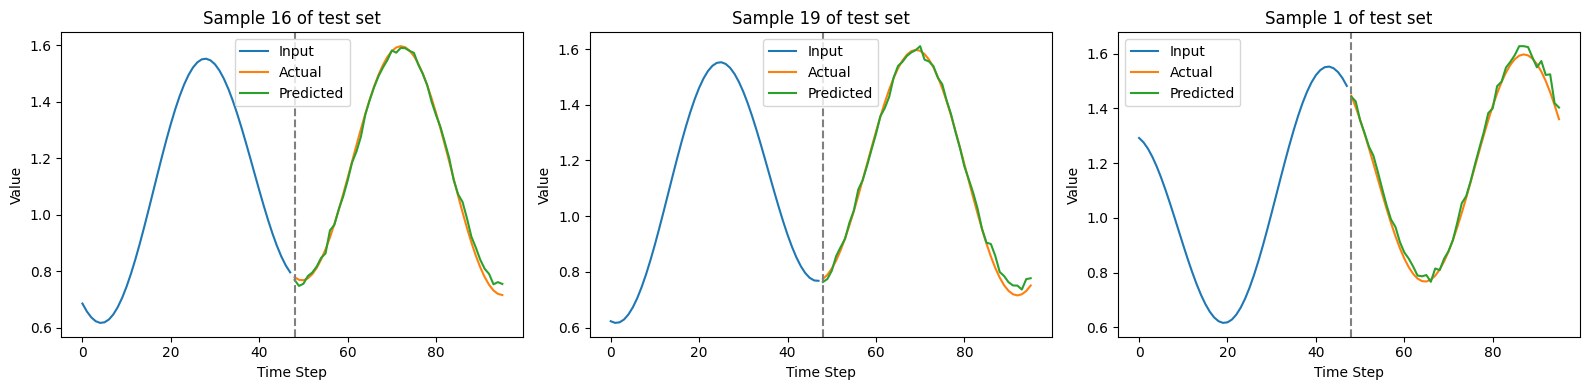

In [19]:
# Test the model on the test set
input_seq, target_seq = next(iter(test_loader))
output = model(input_seq)

# Randomly select 3 samples to visualize
sample_indices = random.sample(range(input_seq.size(0)), 3)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for idx, i in enumerate(sample_indices):
    axs[idx].plot(range(input_len), input_seq[i].numpy(), label='Input')
    axs[idx].plot(range(input_len, input_len + output_len), target_seq[i].detach().numpy(), label='Actual')
    axs[idx].plot(range(input_len, input_len + output_len), output[i].detach().numpy(), label='Predicted')
    axs[idx].axvline(x=input_len, color='gray', linestyle='--')  # Vertical line separating input and output
    axs[idx].set_title(f'Sample {i+1} of test set')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()

plt.tight_layout()
plt.show()

# S4

In [20]:
# Redefine patch embedding
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, d_model):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Linear(patch_size, d_model)

    def forward(self, x):
        B, L = x.shape
        x = x.view(B, L // self.patch_size, self.patch_size)
        x = self.proj(x)
        return x

# Example usage
patch_size = 6
d_model = 10
input_tensor = torch.randn(32, 48) 
# it is also notable that the input tensor should be 2D and patch_size should be a factor of the sequence length
patch_embed = PatchEmbedding(patch_size, d_model)
output = patch_embed(input_tensor)
output.shape

torch.Size([32, 8, 10])

In [21]:
import sys 
import os 
sys.path.append(os.path.abspath("s4/models/s4"))  # Add parent directory to sys.path
from s4 import S4Block  # Import S4 model from the repository
import torch.nn as nn # Import PyTorch's nn module

class S4Model(nn.Module):
    def __init__(self, input_size, output_size, patch_size, d_model):
        super(S4Model, self).__init__()
        # Define the S4 model architecture here
        self.patch_embed = PatchEmbedding(patch_size, d_model)
        self.hidden_size = hidden_size
        self.s4_layer = S4Block(d_model, transposed=False)  # S4 layer definition should be implemented as per the paper
        self.output_layer = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.patch_embed(x) # x shape: (B, L // patch_size, patch_size)
        x, _ = self.s4_layer(x) # x shape: (B, L // patch_size, hidden_size)
        x = self.output_layer(x[:, -1, :]) # x shape: (B, L // patch_size, output_size)
        return x # only the last patch is used for prediction???

# Hyperparameters
input_len = 8 * 6
output_len = 8 * 6  # number of steps to predict
patch_size = 8
d_model = 64

# Model, loss, and optimizer
model = S4Model(input_size=input_len, output_size=output_len, patch_size=patch_size, 
                d_model=d_model)
# output test 
x = torch.rand(32, 48)  # batch size 32, sequence length 48
output = model(x)
print(output.shape)  # should be (32, output_len)

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


torch.Size([32, 48])


In [22]:
# Model initialization S4 
model = S4Model(input_size=input_len, output_size=output_len, patch_size=patch_size, 
                d_model=d_model)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss values
train_losses = []
val_losses = []

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        input_seq, target_seq = batch
        optimizer.zero_grad()
        # input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
        output = model(input_seq)
        # target_seq = target_seq.unsqueeze(-1)  # Add feature dimension
        loss = criterion(output, target_seq)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Testing the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            input_seq, target_seq = batch
            # input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
            output = model(input_seq)
            # target_seq = target_seq.unsqueeze(-1)  # Add feature dimension
            loss = criterion(output, target_seq)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            input_seq, target_seq = batch
            # input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
            output = model(input_seq)
            # target_seq = target_seq.unsqueeze(-1)  # Add feature dimension
            loss = criterion(output, target_seq)
            test_loss += loss.item()
    test_loss /= len(test_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/50, Training Loss: 1.0187, Validation Loss: 0.4862, Test Loss: 0.3388
Epoch 2/50, Training Loss: 0.2474, Validation Loss: 0.2371, Test Loss: 0.1459
Epoch 3/50, Training Loss: 0.1621, Validation Loss: 0.2588, Test Loss: 0.1262
Epoch 4/50, Training Loss: 0.1410, Validation Loss: 0.2726, Test Loss: 0.1063
Epoch 5/50, Training Loss: 0.1230, Validation Loss: 0.2602, Test Loss: 0.0931
Epoch 6/50, Training Loss: 0.0974, Validation Loss: 0.2276, Test Loss: 0.0673
Epoch 7/50, Training Loss: 0.0643, Validation Loss: 0.1853, Test Loss: 0.0450
Epoch 8/50, Training Loss: 0.0382, Validation Loss: 0.1298, Test Loss: 0.0194
Epoch 9/50, Training Loss: 0.0232, Validation Loss: 0.0861, Test Loss: 0.0087
Epoch 10/50, Training Loss: 0.0140, Validation Loss: 0.0498, Test Loss: 0.0043
Epoch 11/50, Training Loss: 0.0083, Validation Loss: 0.0335, Test Loss: 0.0024
Epoch 12/50, Training Loss: 0.0051, Validation Loss: 0.0235, Test Loss: 0.0018
Epoch 13/50, Training Loss: 0.0034, Validation Loss: 0.0174, 

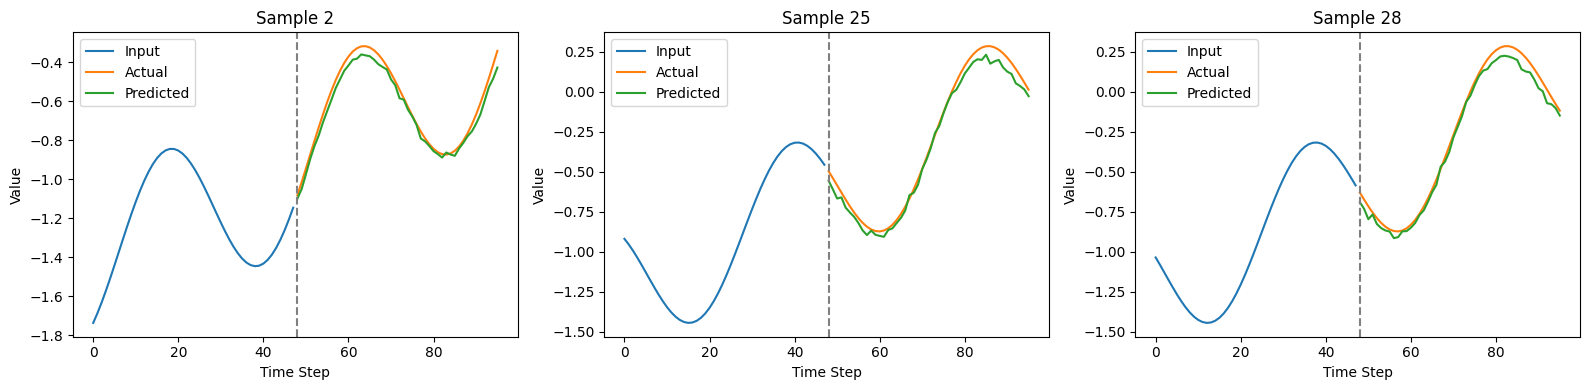

In [23]:
import random
# Randomly select data samples and visualize results
input_seq, target_seq = next(iter(val_loader))
# input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
output = model(input_seq)


# Randomly select 3 samples to visualize
sample_indices = random.sample(range(input_seq.size(0)), 3)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for idx, i in enumerate(sample_indices):
    axs[idx].plot(range(input_len), input_seq[i].numpy(), label='Input')
    axs[idx].plot(range(input_len, input_len + output_len), target_seq[i].detach().numpy(), label='Actual')
    axs[idx].plot(range(input_len, input_len + output_len), output[i].detach().numpy(), label='Predicted')
    axs[idx].axvline(x=input_len, color='gray', linestyle='--')  # Vertical line separating input and output
    axs[idx].set_title(f'Sample {i+1}')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()

plt.tight_layout()
plt.show()

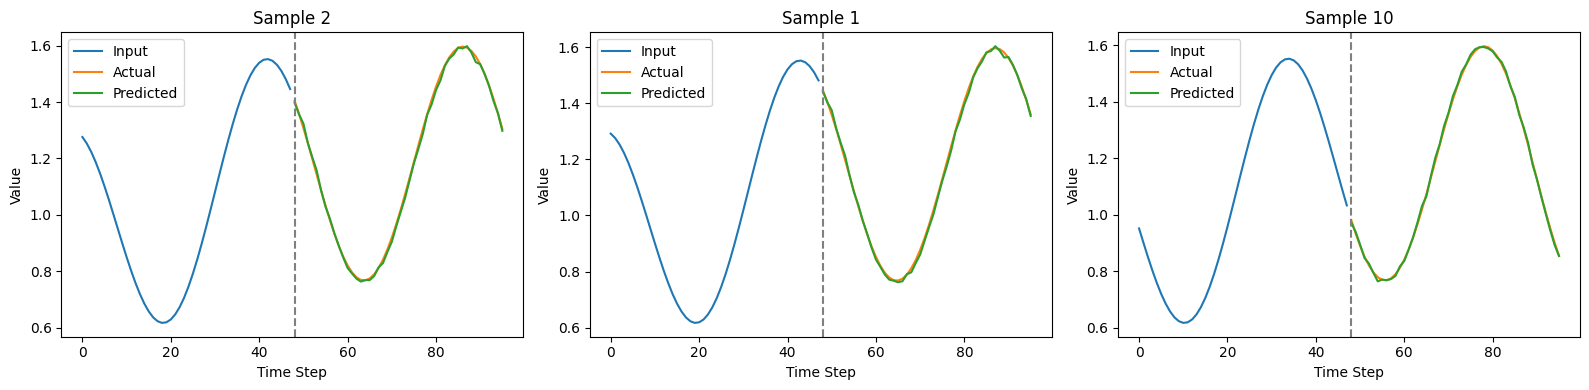

In [24]:
import random
# Randomly select data samples and visualize results
input_seq, target_seq = next(iter(test_loader))
# input_seq = input_seq.unsqueeze(-1)  # Add feature dimension
output = model(input_seq)


# Randomly select 3 samples to visualize
sample_indices = random.sample(range(input_seq.size(0)), 3)

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for idx, i in enumerate(sample_indices):
    axs[idx].plot(range(input_len), input_seq[i].numpy(), label='Input')
    axs[idx].plot(range(input_len, input_len + output_len), target_seq[i].detach().numpy(), label='Actual')
    axs[idx].plot(range(input_len, input_len + output_len), output[i].detach().numpy(), label='Predicted')
    axs[idx].axvline(x=input_len, color='gray', linestyle='--')  # Vertical line separating input and output
    axs[idx].set_title(f'Sample {i+1}')
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel('Value')
    axs[idx].legend()

plt.tight_layout()
plt.show()

# <span style="color:RED"> See more on Mamba_test </span>